#  Homework 5 - Berkeley STAT 157

**Your name: XX, SID YY** (Please add your name, and SID to ease Ryan and Rachel to grade.)

**Please submit your homework through [gradescope](http://gradescope.com/) instead of Github, so you will get the score distribution for each question. Please enroll in the [class](https://www.gradescope.com/courses/42432) by the Entry code: MXG5G5** 

Handout 2/19/2019, due 2/26/2019 by 4pm in Git by committing to your repository.

In this homework, we will model covariate shift and attempt to fix it using logistic regression. This is a fairly realistic scenario for data scientists. To keep things well under control and understandable we will use [Fashion-MNIST](http://d2l.ai/chapter_linear-networks/fashion-mnist.html) as the data to experiment on. 

Follow the instructions from the Fashion MNIST notebook to get the data.

In [1]:
%matplotlib inline
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import numpy as np
from matplotlib import pyplot as plt
import mxnet as mx

mnist_train = gdata.vision.FashionMNIST(train=True)
mnist_test = gdata.vision.FashionMNIST(train=False)

## 1. Logistic Regression

1. Implement the logistic loss function $l(y,f) = -\log(1 + \exp(-y f))$ in Gluon.
2. Plot its values and its derivative for $y = 1$ and $f \in [-5, 5]$, using automatic differentiation in Gluon.
3. Generate training and test datasets for a binary classification problem using Fashion-MNIST with class $1$ being a combination of `shirt` and `sweater` and class $-1$ being the combination of `sandal` and `sneaker` categories. 
4. Train a binary classifier of your choice (it can be linear or a simple MLP such as from a previous lecture) using half the data (i.e. $12,000$ observations mixed as abvove) and one using the full dataset (i.e. $24,000$ observations as arising from the 4 categories) and report its accuracy. 

Hint - you should encapsulate the training and reporting code in a callable function since you'll need it quite a bit in the following. 

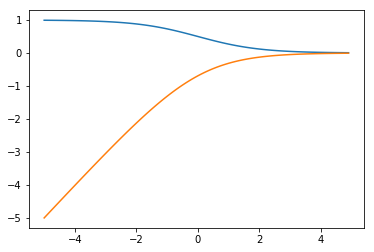

In [3]:
def logisticLoss(f, y):
    return -nd.log(1 + nd.exp(-y * f))

y = nd.ones(1)
f = nd.arange(-5, 5, 0.1)
f.attach_grad()
with autograd.record():
    l = logisticLoss(f, y)
l.backward()

plt.plot(f.asnumpy(), f.grad.asnumpy())
plt.plot(f.asnumpy(), l.asnumpy())
plt.show()


In [250]:
train_features = mnist_train[:][0]
train_labels = mnist_train[:][1]
test_features = mnist_test[:][0]
test_labels = mnist_test[:][1]

In [251]:
train_shoes = [nd.array(x, dtype='float32') for x, y in zip(train_features, train_labels) if y == 5 or y == 7]
train_cloths = [nd.array(x, dtype='float32') for x, y in zip(train_features, train_labels) if y == 2 or y == 6]
train = train_shoes + train_cloths

a = nd.repeat(nd.array([-1], dtype='float32'), repeats = 12000)
b = nd.repeat(nd.array([1], dtype='float32'), repeats = 12000)
train_label = nd.concat(a, b, dim=0)

In [237]:
test_shoes = [nd.array(x, dtype='float32') for x, y in zip(test_features, test_labels) if y == 5 or y == 7]
test_cloths = [nd.array(x, dtype='float32') for x, y in zip(test_features, test_labels) if y == 2 or y == 6]
test = test_shoes + test_cloths

a = nd.repeat(nd.array([-1], dtype='float32'), repeats = 2000)
b = nd.repeat(nd.array([1], dtype='float32'), repeats = 2000)
test_label = nd.concat(a, b, dim=0)

In [238]:
batch_size = 64

In [239]:
train_iter = gdata.DataLoader(gdata.ArrayDataset(
    train, train_label), batch_size, shuffle=True)

test_iter = gdata.DataLoader(gdata.ArrayDataset(
    test, test_label), batch_size, shuffle=False)

In [257]:
net = nn.Sequential()
net.add(nn.Dense(1))
net.initialize()


In [271]:
num_epochs = 5
loss = logisticLoss
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

In [272]:
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y = y.astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum().asscalar()
        n += y.size
    return acc_sum / n

In [273]:
for epoch in range(num_epochs):
    for X, y in train_iter:
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(batch_size)
    test_acc = evaluate_accuracy(test_iter, net)
    print(test_acc)

0.0
0.0
0.0
0.0
0.0


In [248]:
net[0].weight.data()


[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan

## 3. Covariate Shift Correction

Having observed that covariate shift can be harmful, let's try fixing it. For this we first need to compute the appropriate propensity scores $\frac{dp(x)}{dq(x)}$. For this purpose pick a biased dataset, let's say with $\lambda = 0.1$ and try to fix the covariate shift.

1. When training a logistic regression binary classifier to fix covariate shift, we assumed so far that both sets are of equal size. Show that re-weighting data in training and test set appropriately can help address the issue when both datasets have different size. What is the weighting?
2. Train a binary classifier (using logistic regression) distinguishing between the biased training set and the unbiased test set. Note - you need to weigh the data. 
3. Use the scores to compute weights on the training set. Do they match the weight arising from the biasing distribution $\lambda$? 
4. Train a binary classifier of the covariate shifted problem using the weights obtained previously and report the accuracy. Note - you will need to modify the training loop slightly such that you can compute the gradient of a weighted sum of losses. 
